In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
from tqdm.notebook import tqdm

In [2]:
data = torch.load("sentence_embed.pt")
#unique = torch.load("unique.pt")
# df = pandas.read_csv("../../mimic_impressions.csv")

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
norms = torch.stack([torch.norm(data[a]) for a in data]).to(device)
values = torch.stack([data[a] for a in sorted(data.keys())]).to(device)
cuda_data = [data[a].to(device) for a in data]
print(values.size(), norms.size(), len(cuda_data), device)

torch.Size([454265, 768]) torch.Size([454265]) 454265 cuda:0


In [17]:
sizes = []
cutoffs = [0.99, 0.95, 0.9, 0.85, 0.75, 0.6, 0.4, 0.2]
# cutoffs = [0.98, 0.95, 0.9, 0.85, 0.65, 0.4, 0.2]
for cutoff in cutoffs[::-1]:
    x = {}
    copy = set()
    pbar = tqdm(total=len(data))
    idxs = set(range(len(data)))
    values_copy = values.detach().clone().to(device)
    while len(idxs) != 0:
        i = min(idxs)
        cos = values_copy @ cuda_data[i] / (norms * norms[i])
        same_t = torch.where(cos > cutoff)[0]
        same = set(same_t.tolist())
        copy.update(same)
        x[i] = same
        idxs -= same
        idxs -= {i}
        values_copy[same_t, :] *= 0.
        pbar.update(1)
    pbar.close()
    print(cutoff, len(x))
    sizes.append(len(x))
    num = int(cutoff*100)
    torch.save(x, f"sentences_{num}.pt")


0.2 10



0.4 36



0.6 265



0.75 1546



0.85 7510



0.9 20470



0.95 61496



0.99 167272


In [15]:
# torch.save(x, "sentences_95.pt")

In [18]:
print(len(x))
print(list(x.keys())[:10])
print(x[10])
print(sizes, cutoffs)

167272
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10]
{10, 238068, 285119}
[10, 36, 265, 1546, 7510, 20470, 61496, 167272] [0.99, 0.95, 0.9, 0.85, 0.75, 0.6, 0.4, 0.2]


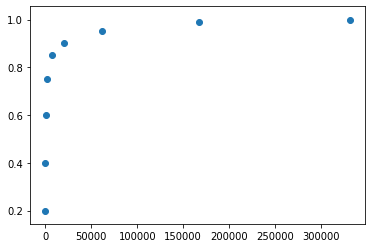

In [19]:
plt.scatter(sizes + [331007], cutoffs[::-1] + [1.0])
plt.show()

In [11]:
a, b = data[0], data[2]
print(a @ b / (torch.norm(a) * torch.norm(b)))

tensor(0.9468)


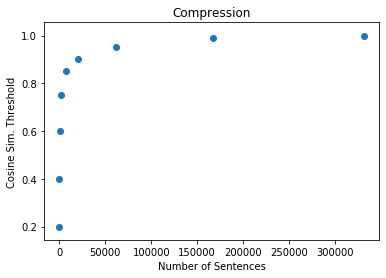

In [20]:
plt.scatter(sizes + [331007], cutoffs[::-1] + [1.00])
plt.title("Compression")
plt.xlabel("Number of Sentences")
plt.ylabel("Cosine Sim. Threshold")
plt.savefig("./compress_sentences.png")